<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/homework07/homework07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 07

In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.layers import Dense, Conv2D, AveragePooling2D, TimeDistributed, LSTM, GlobalAvgPool2D, AbstractRNNCell, MaxPooling2D
from keras.initializers import Orthogonal
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
# Load MNIST dataset
def load_data():
    (train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
    return (train_ds, test_ds), ds_info

In [3]:
# Creating new target
def new_target_fnc(ds, window_size):
  l = list()
  for i, elem in enumerate(ds):
    if (i % window_size) == 0:
      l.append(int(elem[1]))
    else:
      if (i % 2) == 0:
        l.append(int(l[i-1] + elem[1]))
      else:
        l.append(int(l[i-1] - elem[1]))
  return l

# Preprocessing data
def preprocess(data, batch_size, window_size):
  new_targets = new_target_fnc(data, window_size)
  new_targets = tf.data.Dataset.from_tensor_slices(new_targets)

  data = tf.data.Dataset.zip((data, new_targets))
  data = data.map(lambda img, new_target: (img[0], new_target))
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=37)))

  data = data.map(lambda img, target: (img, tf.cast(target, tf.float32)))

  data = data.map(lambda img, target: (img,target))

  data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
  data = data.map(lambda img, target: ((img/128.)-1., target))

  data = data.batch(window_size, drop_remainder=True)
  data = data.batch(batch_size, drop_remainder=True)
  data = data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
  return data

In [4]:
# CNN Model
class CNN(tf.keras.Model):
  def __init__(self, input_shape):
    super().__init__()
    # input conv1 = 28x28x1
    self.conv1 = TimeDistributed(Conv2D(24, 3, activation='relu', padding='valid'), input_shape=input_shape)
    # output conv1 = 28x28x24
    self.conv2 = TimeDistributed(Conv2D(24, 3, activation='relu', padding='valid'))
    # output conv2 = 28x28x24
    self.pooling1 = TimeDistributed(MaxPooling2D())
    # output pooling1 = 14x14x24
    self.conv3 = TimeDistributed(Conv2D(24, 3, activation='relu', padding='valid'))
    # output conv3 = 14x14x24
    self.conv4 = TimeDistributed(Conv2D(24, 3, activation='relu', padding='valid'))
    # output conv3 = 14x14x24
    self.globalpooling = TimeDistributed(GlobalAvgPool2D())
    # output globalpooling = 7x7x24
    self.out = TimeDistributed(Dense(10, activation="softmax"))


  @tf.function
  def __call__(self, x, training=False):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = self.globalpooling(x)
    x = self.out(x)
    return x

In [5]:
class LSTMCell(AbstractRNNCell):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)

        self.hidden_state_units = 50
        self.cell_state_units = 50
        self.input_size = 1

        self.forget_gate = Dense(self.cell_state_units, activation="sigmoid", kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None))
        self.input_gate = Dense(self.cell_state_units, activation="sigmoid", kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None))
        self.cell_state_candidates = Dense(self.cell_state_units, activation="tanh", kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None))
        self.output_gate = Dense(self.hidden_state_units, activation="sigmoid", kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None))

    @property
    def state_size(self):
        return [tf.TensorShape([self.hidden_state_units]), 
                tf.TensorShape([self.cell_state_units])]

    @property
    def output_size(self):
        return [tf.TensorShape([self.hidden_state_units])]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros(shape=[32,self.hidden_state_units]), 
                tf.zeros(shape=[32,self.cell_state_units])]

    def call(self, inputs, states):

        hidden_state = states[0]
        cell_state = states[1]

        hidden_and_input_concat = tf.concat([hidden_state, tf.convert_to_tensor(inputs)], axis=-1)
        hidden_and_input_concat = tf.convert_to_tensor(hidden_and_input_concat)

        forget_filter = self.forget_gate(hidden_and_input_concat)
        input_filter = self.input_gate(hidden_and_input_concat)
        candidate_vector = self.cell_state_candidates(hidden_and_input_concat)

        cell_state_with_forgetting = cell_state * forget_filter
        cell_state = cell_state_with_forgetting + input_filter * candidate_vector

        output_filter = self.output_gate(hidden_and_input_concat)

        tanh_of_cell_state = tf.math.tanh(cell_state)
        hidden_state = output_filter * tanh_of_cell_state
        
        return hidden_state, [hidden_state, cell_state]

In [6]:
class OverallModel(tf.keras.Model):
  def __init__(self, cnn, lstm, optimizer, loss_function):
    super().__init__()

    self.cnn = cnn
    self.lstm = lstm
    self.output_layer = Dense(37,activation='softmax')

    self.metrics_list = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer
    self.loss_function = loss_function

  @property
  def metrics(self):
    return self.metrics_list
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, sequence, training = False):
    cnn_output = self.cnn(sequence)
    cnn_number = tf.argmax(cnn_output, axis=-1)
    lstm_output = self.lstm(cnn_output)
    output = self.output_layer(lstm_output)
    return output

  @tf.function
  def training_step(self, image, label):

    with tf.GradientTape() as tape: 
      prediction = self(image, training = True)

      loss = self.loss_function(label, prediction)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    self.metrics[0].update_state(label, prediction)
    self.metrics[1].update_state(loss)  

  @tf.function
  def test_step(self, data):
    image, label = data
    prediction = self(image, training = False)
    loss = self.loss_function(label, prediction)
    self.metrics[0].update_state(label, prediction)
    self.metrics[1].update_state(loss)



In [17]:
# Training Loop
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    # list for plotting
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    # looping over epoch
    for epoch in range (epochs):
        model.reset_metrics()
        for data in tqdm(train_ds, position=0, leave=True):

            model.training_step(image=data[0], label=data[1])      

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")

        # updating loss and accuracy result to list
        train_loss.append(model.metrics[1].result().numpy())
        train_accuracy.append(model.metrics[0].result().numpy())

        model.reset_metrics()

        for data in test_ds:
            model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")
        
        # updating loss and accuracy result to list
        test_loss.append(model.metrics[1].result().numpy())
        test_accuracy.append(model.metrics[0].result().numpy())
    
    model.save_weights(save_path) 
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [8]:
# train the model

batch_size = 32
window_size = 4
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, batch_size, window_size)
test_ds = preprocess(test_ds, batch_size, window_size)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [21]:

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(input_shape=(window_size, 28, 28, 1))
lstm_cell = LSTMCell()
lstm_layer = tf.keras.layers.RNN(lstm_cell, return_sequences=True, unroll=True)
model = OverallModel(cnn=cnn, lstm=lstm_layer, optimizer=optimizer, loss_function=loss_function)
epochs = 50

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)


(train_loss, train_accuracy, test_loss, test_accuracy) = training_loop(
    model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 468/468 [01:31<00:00,  5.14it/s]


Epoch:  1
Loss:  2.0227046 Accuracy:  0.118022166 (Train)
Loss:  1.8662698 Accuracy:  0.083834134 (Test)


100%|██████████| 468/468 [01:28<00:00,  5.29it/s]


Epoch:  2
Loss:  1.8431312 Accuracy:  0.14671808 (Train)
Loss:  1.8358082 Accuracy:  0.07491987 (Test)


100%|██████████| 468/468 [01:29<00:00,  5.26it/s]


Epoch:  3
Loss:  1.8267418 Accuracy:  0.17280982 (Train)
Loss:  1.8288107 Accuracy:  0.07972757 (Test)


100%|██████████| 468/468 [01:25<00:00,  5.46it/s]


Epoch:  4
Loss:  1.8210468 Accuracy:  0.1708734 (Train)
Loss:  1.8246778 Accuracy:  0.07892628 (Test)


100%|██████████| 468/468 [01:28<00:00,  5.31it/s]


Epoch:  5
Loss:  1.8168719 Accuracy:  0.1562834 (Train)
Loss:  1.8197821 Accuracy:  0.35667068 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.61it/s]


Epoch:  6
Loss:  1.8145943 Accuracy:  0.1822082 (Train)
Loss:  1.8186166 Accuracy:  0.07652243 (Test)


100%|██████████| 468/468 [01:26<00:00,  5.44it/s]


Epoch:  7
Loss:  1.8127812 Accuracy:  0.16751803 (Train)
Loss:  1.8148861 Accuracy:  0.07972757 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.61it/s]


Epoch:  8
Loss:  1.8106555 Accuracy:  0.17788461 (Train)
Loss:  1.8150132 Accuracy:  0.07652243 (Test)


100%|██████████| 468/468 [01:26<00:00,  5.44it/s]


Epoch:  9
Loss:  1.8095709 Accuracy:  0.17371127 (Train)
Loss:  1.8140997 Accuracy:  0.35346556 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.66it/s]


Epoch:  10
Loss:  1.8084644 Accuracy:  0.16266026 (Train)
Loss:  1.8119802 Accuracy:  0.35346556 (Test)


100%|██████████| 468/468 [01:25<00:00,  5.50it/s]


Epoch:  11
Loss:  1.8075663 Accuracy:  0.17374466 (Train)
Loss:  1.8121848 Accuracy:  0.080629006 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.67it/s]


Epoch:  12
Loss:  1.806292 Accuracy:  0.17369458 (Train)
Loss:  1.8122271 Accuracy:  0.35346556 (Test)


100%|██████████| 468/468 [01:25<00:00,  5.48it/s]


Epoch:  13
Loss:  1.8054917 Accuracy:  0.16877003 (Train)
Loss:  1.8143722 Accuracy:  0.19541267 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.69it/s]


Epoch:  14
Loss:  1.8049232 Accuracy:  0.2048611 (Train)
Loss:  1.8128834 Accuracy:  0.07491987 (Test)


100%|██████████| 468/468 [01:26<00:00,  5.43it/s]


Epoch:  15
Loss:  1.8043841 Accuracy:  0.17234242 (Train)
Loss:  1.8092501 Accuracy:  0.35346556 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.67it/s]


Epoch:  16
Loss:  1.8035915 Accuracy:  0.17015558 (Train)
Loss:  1.8105298 Accuracy:  0.07652243 (Test)


100%|██████████| 468/468 [01:24<00:00,  5.53it/s]


Epoch:  17
Loss:  1.8030226 Accuracy:  0.15319511 (Train)
Loss:  1.8084909 Accuracy:  0.19741586 (Test)


100%|██████████| 468/468 [01:21<00:00,  5.77it/s]


Epoch:  18
Loss:  1.8025559 Accuracy:  0.1787026 (Train)
Loss:  1.8058045 Accuracy:  0.20082131 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.62it/s]


Epoch:  19
Loss:  1.8018909 Accuracy:  0.15406317 (Train)
Loss:  1.8088318 Accuracy:  0.083834134 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.81it/s]


Epoch:  20
Loss:  1.8014941 Accuracy:  0.17501335 (Train)
Loss:  1.8060751 Accuracy:  0.07822516 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.61it/s]


Epoch:  21
Loss:  1.8015028 Accuracy:  0.19148971 (Train)
Loss:  1.8049494 Accuracy:  0.080629006 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.81it/s]


Epoch:  22
Loss:  1.8011533 Accuracy:  0.16319445 (Train)
Loss:  1.8053399 Accuracy:  0.08042868 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.62it/s]


Epoch:  23
Loss:  1.8007842 Accuracy:  0.18394431 (Train)
Loss:  1.8054407 Accuracy:  0.07371795 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.83it/s]


Epoch:  24
Loss:  1.8004159 Accuracy:  0.17669939 (Train)
Loss:  1.808091 Accuracy:  0.23587741 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.65it/s]


Epoch:  25
Loss:  1.7998738 Accuracy:  0.17391159 (Train)
Loss:  1.8038129 Accuracy:  0.07972757 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.70it/s]


Epoch:  26
Loss:  1.7995892 Accuracy:  0.1630776 (Train)
Loss:  1.8073214 Accuracy:  0.083834134 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.69it/s]


Epoch:  27
Loss:  1.7996293 Accuracy:  0.17755075 (Train)
Loss:  1.8082333 Accuracy:  0.35667068 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.69it/s]


Epoch:  28
Loss:  1.7990476 Accuracy:  0.17811832 (Train)
Loss:  1.8050083 Accuracy:  0.07652243 (Test)


100%|██████████| 468/468 [01:21<00:00,  5.71it/s]


Epoch:  29
Loss:  1.799333 Accuracy:  0.16614917 (Train)
Loss:  1.8046519 Accuracy:  0.080629006 (Test)


100%|██████████| 468/468 [02:21<00:00,  3.30it/s]


Epoch:  30
Loss:  1.7989459 Accuracy:  0.19626403 (Train)
Loss:  1.8039697 Accuracy:  0.081430286 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.82it/s]


Epoch:  31
Loss:  1.7990766 Accuracy:  0.1796875 (Train)
Loss:  1.8028469 Accuracy:  0.23527645 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.63it/s]


Epoch:  32
Loss:  1.7984738 Accuracy:  0.16214277 (Train)
Loss:  1.8040087 Accuracy:  0.083834134 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.81it/s]


Epoch:  33
Loss:  1.7983929 Accuracy:  0.15706797 (Train)
Loss:  1.8039138 Accuracy:  0.08042868 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.63it/s]


Epoch:  34
Loss:  1.7983127 Accuracy:  0.15873732 (Train)
Loss:  1.8052503 Accuracy:  0.08042868 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.82it/s]


Epoch:  35
Loss:  1.7984049 Accuracy:  0.18875201 (Train)
Loss:  1.8045946 Accuracy:  0.08042868 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.61it/s]


Epoch:  36
Loss:  1.7981777 Accuracy:  0.15329528 (Train)
Loss:  1.8023071 Accuracy:  0.23677884 (Test)


100%|██████████| 468/468 [01:21<00:00,  5.78it/s]


Epoch:  37
Loss:  1.7977384 Accuracy:  0.17124066 (Train)
Loss:  1.8044013 Accuracy:  0.083834134 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.60it/s]


Epoch:  38
Loss:  1.797591 Accuracy:  0.17674947 (Train)
Loss:  1.802298 Accuracy:  0.35667068 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.79it/s]


Epoch:  39
Loss:  1.7975489 Accuracy:  0.17326055 (Train)
Loss:  1.8025937 Accuracy:  0.23287259 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.60it/s]


Epoch:  40
Loss:  1.7974174 Accuracy:  0.16638288 (Train)
Loss:  1.806206 Accuracy:  0.35667068 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.81it/s]


Epoch:  41
Loss:  1.7972081 Accuracy:  0.1701055 (Train)
Loss:  1.8035098 Accuracy:  0.080629006 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.62it/s]


Epoch:  42
Loss:  1.7971288 Accuracy:  0.18202457 (Train)
Loss:  1.804024 Accuracy:  0.081430286 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.80it/s]


Epoch:  43
Loss:  1.797249 Accuracy:  0.15344551 (Train)
Loss:  1.8024076 Accuracy:  0.083834134 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.61it/s]


Epoch:  44
Loss:  1.797007 Accuracy:  0.17247596 (Train)
Loss:  1.8024173 Accuracy:  0.35667068 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.79it/s]


Epoch:  45
Loss:  1.7970308 Accuracy:  0.16825254 (Train)
Loss:  1.800314 Accuracy:  0.23287259 (Test)


100%|██████████| 468/468 [01:23<00:00,  5.60it/s]


Epoch:  46
Loss:  1.7965105 Accuracy:  0.15619992 (Train)
Loss:  1.8011956 Accuracy:  0.081430286 (Test)


100%|██████████| 468/468 [01:21<00:00,  5.77it/s]


Epoch:  47
Loss:  1.7965693 Accuracy:  0.18132345 (Train)
Loss:  1.8016577 Accuracy:  0.23287259 (Test)


100%|██████████| 468/468 [01:22<00:00,  5.69it/s]


Epoch:  48
Loss:  1.7965692 Accuracy:  0.1706063 (Train)
Loss:  1.8033915 Accuracy:  0.23287259 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.79it/s]


Epoch:  49
Loss:  1.7965615 Accuracy:  0.17621528 (Train)
Loss:  1.8016827 Accuracy:  0.079527244 (Test)


100%|██████████| 468/468 [01:20<00:00,  5.79it/s]


Epoch:  50
Loss:  1.7961439 Accuracy:  0.17546408 (Train)
Loss:  1.8031341 Accuracy:  0.23607773 (Test)


## Plotting the result

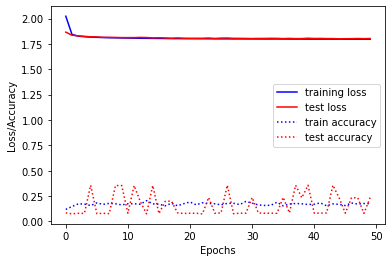

In [22]:
plt.figure()
line1 , = plt.plot(train_loss , "b-")
line2 , = plt.plot(test_loss , "r-") 
line3 , = plt.plot(train_accuracy , "b:")
line4 , = plt.plot(test_accuracy , "r:") 
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
plt.show()